# Modelling count data with Tensoflow Probability

**Goal:** In this notebook you will again work with TFP. You will set up regression models that are able to output a poissonian conditional probability distribution. You will define different models with Keras, sklearn and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You will model the conditional probability distribution as a Poisson distribution.
You compare the performace of the Poisson regression vs. the linear regression on a test dataset. Finally, you will extend the Poisson Distribution to the zero-inflated Poisson distribution and compare the NLL of all models.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** 
You work with a dataset form https://stats.idre.ucla.edu/r/dae/zip/. The dataset contains data on 250 groups that went to a park. Each group was questioned about how many fish they caught (count), how many children were in the group (child), how many people were in the group (persons), if they used a live bait  and whether or not they brought a camper to the park (camper).
You split the data into train and test dataset.

**Content:**
* Work with a Poisson distribution in TFP
* Load and split the dataset 
* Fit a linear regression model sklearn and compute the minimal NLL with the optimal $\sigma$
* Fit a linear regression model keras and compute the minimal NLL with the optimal $\sigma$
* Fit a poisson regression model with keras and TFP
* Fit a zero-inflated poisson regression model with keras and TFP 
* Compare the different models based on the NLL loss on the test dataset

| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_05/nb_ch05_02.ipynb)


In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-rc0
        !pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-rc0  running in colab?:  True


In [2]:
!pip install scikit-misc

#### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-rc0


### Working with a TFP Poisson distribution

Here you can see small example how to work with Poisson distribution in TFP, we set the rate $\lambda$ to 2, and plot the Probability mass function for the values 0 to 10. Below in the notebook you will define a model to learn this parameter.

2.0
1.4142135


Text(0, 0.5, 'Probability')

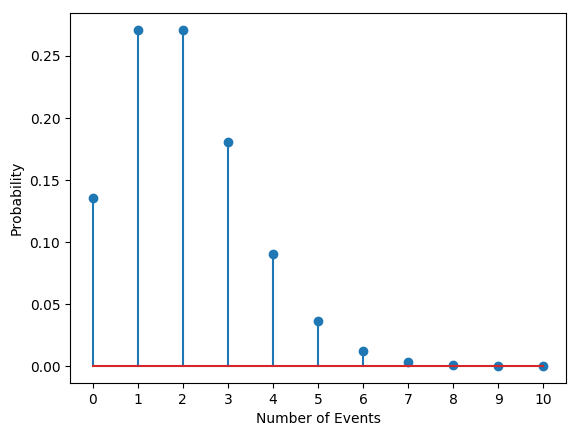

In [4]:
dist = tfd.poisson.Poisson(rate = 2) #A
vals = np.linspace(0,10,11) #B
p = dist.prob(vals) #C
print(dist.mean().numpy())  #D
print(dist.stddev().numpy())   #E
plt.xticks(vals)
plt.stem(vals, p)
plt.xlabel('Number of Events')
plt.ylabel('Probability')

#A Poisson distribution with parameter rate 2
#B some values for the x-axis in figure 5.rain
#C the probability for the values
#D the mean value yielding 2.0
#E the standard deviation yielding sqrt(2.0) = 1.41...

### Loading real count data

Here you load traditional count data from: https://stats.idre.ucla.edu/r/dae/zip/. The traget variable will be the number fish caught during a state park visit by a group. You have data on 250 groups that went to a park. Each group was questioned about how many fish they caught (count), how many children were in the group (child), how many people were in the group (persons), if they used a live bait (livebait) and whether or not they brought a camper to the park (camper). This will be the predictors.
You randomly split the data into train and test dataset (80% train and 20% test).

In [0]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/fish.csv',delimiter=',', skiprows=1)
X = dat[...,1:5] #"livebait","camper","persons","child
y = dat[...,7]

In [0]:
# Uncomment the next line, to enhance the ZIP model (see below why you would like to do it)
# n = len(y)
# idx = np.random.permutation(n)[0:int(n*0.3)] 
# y[idx] = 0

Let's split the data and look at the counts (how many fish each group caught).


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
d = X_train.shape[1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape,dat.shape, y_test[0:10], y_train[0:10]

((200, 4),
 (200,),
 (50, 4),
 (50,),
 (250, 8),
 array([0., 0., 2., 2., 0., 0., 0., 0., 1., 0.]),
 array([ 6.,  1.,  6.,  1.,  3.,  1.,  0., 15.,  0.,  2.]))

In the following we will at the number of fish each group caught. 

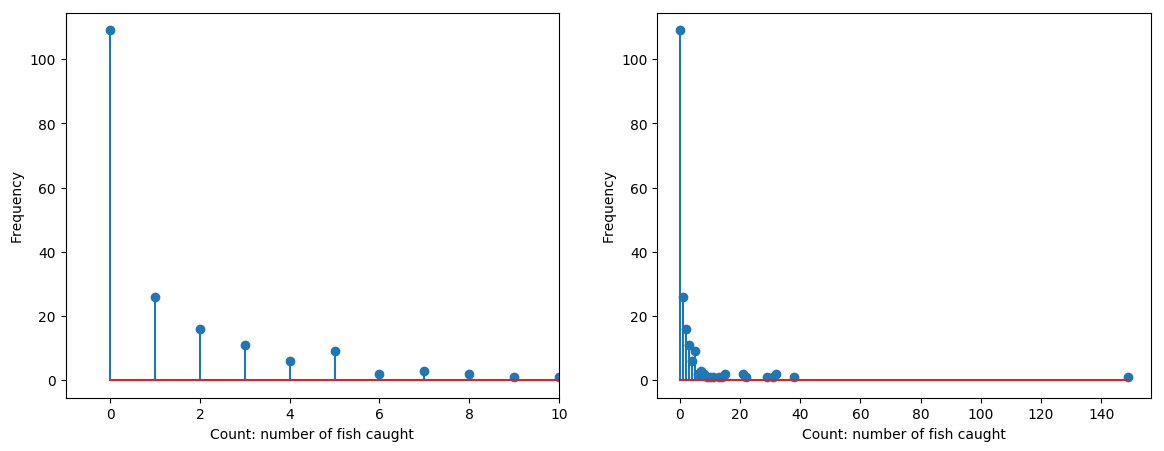

149.0

In [8]:
plt.figure(figsize=(14,5))

vals, counts = np.unique(y_train, return_counts=True)
plt.subplot(1,2,1)
plt.stem(vals, counts)
plt.xlabel('Count: number of fish caught')
plt.ylabel('Frequency')
plt.xlim(-1,10)
plt.subplot(1,2,2)
plt.stem(vals, counts)
plt.xlabel('Count: number of fish caught')
plt.ylabel('Frequency')
plt.show()
np.max(y_train)

You see that most of the groups didn't caught any fish at all. The number of fish caught is between 1 and 8 fish, there is only one group that was very successful and caught 149 fish!

## Fit linear regression model with constant variance

In the next few cells you will ignore the fact that you are dealing with count data here and just fit a linear regression model with constant variance to the data. You will fist do this with sklearn and then with keras. You will use the standart MSE loss and use the formula to calculate the optimal standart deviation to minimize the NLL. Finally, you predict the test data and compare the performance with the RSME, MAE and the NLL. 

### Linear regression with sklearn 
 
Let's fist fit the linear regression with sklean on the training data.

In [0]:
# The linear regression using non deep learning methods
# These methods have no problem with convergence 
from sklearn.linear_model import LinearRegression
model_skl = LinearRegression()
res = model_skl.fit(X_train, y_train)

In linear regression, we assuming that the $\sigma$ is constant. To calculate the NLL, we need to estimate this quantity from the training data. But the prediction is of course done on the testdata. Note that we calculate the mean NLL.

In [10]:
import pandas as pd
# Calculation of the the optimal sigma 
y_hat_train = model_skl.predict(X_train)
n = len(y_hat_train)
sigma_hat_2 = (n-1.)/(n-2.) * np.var(y_train - y_hat_train.flatten(),ddof=1)
print('Estimated variance ', sigma_hat_2)
print('Estimated standart deviation ', np.sqrt(sigma_hat_2))

y_hat = model_skl.predict(X_test) #Prediction on the testset
RMSE_skl = np.sqrt(np.mean((y_test - y_hat.flatten())**2))
MAE_skl = np.mean(np.abs(y_test- y_hat.flatten())) 

NLL_skl =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_test - y_hat.flatten())**2)/sigma_hat_2
print('NLL on training:', 0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_train - y_hat_train.flatten())**2)/sigma_hat_2)

df1 = pd.DataFrame(
          {'RMSE' : RMSE_skl, 'MAE' : MAE_skl, 'NLL (mean)' : NLL_skl}, index=['Linear Regression (sklearn)']
)
df1

Estimated variance  118.45401800694137
Estimated standart deviation  10.883658300725054
NLL on training: 3.801200958991639


,RMSE,MAE,NLL (mean)
Linear Regression (sklearn),8.588126,4.70509,3.617528


### Linear regression with Keras 
 
Let's do the same as before with sklearn, but this time you use a linear regression  model with keras.
You have 4 inputs (child , persons livebait, camper) and 1 output (count). Note that you'll use the standart MSE loss.

In [0]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.optimizers import Adam

model_lr = Sequential() 
model_lr.add(Dense(1,input_dim=d, activation='linear')) 
model_lr.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.01))

In [12]:
hist_lr = model_lr.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=5000, verbose=0, batch_size=len(y_train))

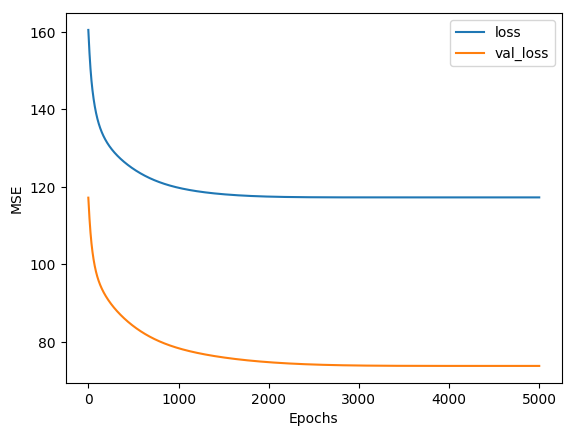

In [13]:
plt.plot(hist_lr.history['loss']) #Note this is the MSE and not the RMSE
plt.plot(hist_lr.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [14]:
# Calculation of the the optimal sigma 
y_hat_train = model_lr.predict(X_train)
sigma_hat_2 = (n-1.)/(n-2.) * np.var(y_train - y_hat_train.flatten(),ddof=1)
print('Estimated variance ', sigma_hat_2)
print('Estimated standart deviation ', np.sqrt(sigma_hat_2))

y_hat = model_lr.predict(X_test) #Prediction on the testset
RMSE_lr = np.sqrt(np.mean((y_test - y_hat.flatten())**2))
MAE_lr = np.mean(np.abs(y_test - y_hat.flatten())) 

NLL_lr =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_test - y_hat.flatten())**2)/sigma_hat_2
print('NLL on training:', 0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_train - y_hat_train.flatten())**2)/sigma_hat_2)

df2 = pd.DataFrame(
          {'RMSE' : RMSE_lr, 'MAE' : MAE_lr, 'NLL (mean)' : NLL_lr}, index=['Linear Regression (MSE Keras)']
)
pd.concat([df1,df2])

Estimated variance  118.45401861383469
Estimated standart deviation  10.883658328605998
NLL on training: 3.801200961553415


,RMSE,MAE,NLL (mean)
Linear Regression (sklearn),8.588126,4.705090,3.617528
Linear Regression (MSE Keras),8.588128,4.705087,3.617528


Here we are comparing the coefficients of the keras and sklearn linear regression models. As you can see we get the same results! The RMSE, MAE and the NLL are also the same.

In [15]:
print('weights using deep learning:          ',model_lr.get_weights()[0][:,0])
print('weights from sklearn:                 ',res.coef_)
print('Intercept (bias) using deep learning: ',model_lr.get_weights()[1][0])
print('Intercept (bias) using sklearn:       ',res.intercept_)

weights using deep learning:           [ 2.482187   2.954299   4.6495247 -5.471593 ]
weights from sklearn:                  [ 2.4822138   2.95430727  4.64953914 -5.47160051]
Intercept (bias) using deep learning:  -8.492166
Intercept (bias) using sklearn:        -8.492228208419725


#### Evaluation of the Performance 
Let's plot the predicted values of the the linear regression model. vs the true values on the train and test dataset.

In [0]:
from skmisc.loess import loess

def plot_loess(preds,true):
  l = loess(preds.flatten()[np.argsort(preds,axis=0)].flatten(),true[np.argsort(preds,axis=0)].flatten())
  l.fit()
  pred = l.predict(preds.flatten()[np.argsort(preds,axis=0)].flatten(), stderror=True)
  conf = pred.confidence()
  lowess = pred.values
  ll = conf.lower
  ul = conf.upper
  plt.plot(preds.flatten()[np.argsort(preds,axis=0)].flatten(), lowess)
  plt.fill_between(preds.flatten()[np.argsort(preds,axis=0)].flatten(),ll,ul,alpha=.33)
  plt.plot(preds.flatten()[np.argsort(preds,axis=0)].flatten(), lowess)
  x_ = preds.flatten()[np.argsort(preds,axis=0)].flatten()
  y_ = x_
  plt.plot(x_,y_,linestyle='dashed',c="b")


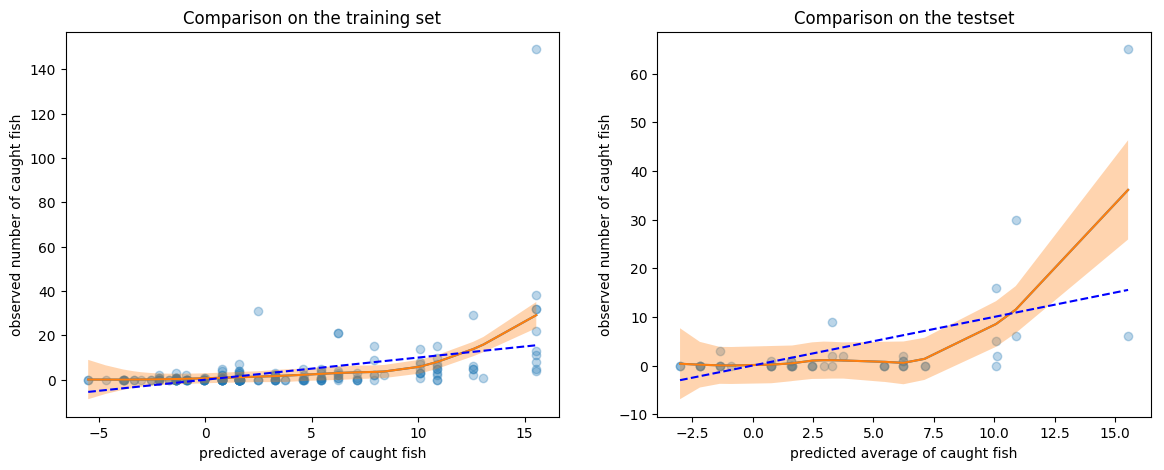

In [17]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(model_lr.predict(X_train), y_train,alpha=0.3)
plot_loess(model_lr.predict(X_train),y_train)
plt.title('Comparison on the training set')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')

plt.subplot(1,2,2) 
plt.scatter(model_lr.predict(X_test), y_test,alpha=0.3)
plot_loess(model_lr.predict(X_test),y_test)
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.show()

You can see that the prediction aren't that good. Note that the linear model predicts also negative values, which is obviously wrong. 

## Poisson Regression 

Now you use  the TFP framework and the Poission distribution to model the output of the network as a Poissonian conditional probability distribution. You will not use any hidden layers in between and the loss will be the NLL. After the fitting, you predict the test data and compare the performance with the linear regression model.
$$
    Y \thicksim \tt{Pois}(exp(w^{T} \cdot x + b))
$$

In [18]:
inputs = Input(shape=(X_train.shape[1],))  
rate = Dense(1, 
         activation=tf.exp)(inputs) #A
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) #B 

model_p = Model(inputs=inputs, outputs=p_y) #C


def NLL(y_true, y_hat): #D
  return -y_hat.log_prob(y_true)

model_p.compile(Adam(learning_rate=0.01), loss=NLL)
model_p.summary()

#A Definition of a single layer with one output
#B We use exponential of the output to model the rate
#C Glueing input and output together. Note that output is a tf.distribution
#D Since the second argument is the output of the model it is a distribution. It's as simple as calling log_prob to calculate the NLL.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [19]:
hist_p = model_p.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

Text(0.5, 0, 'Epochs')

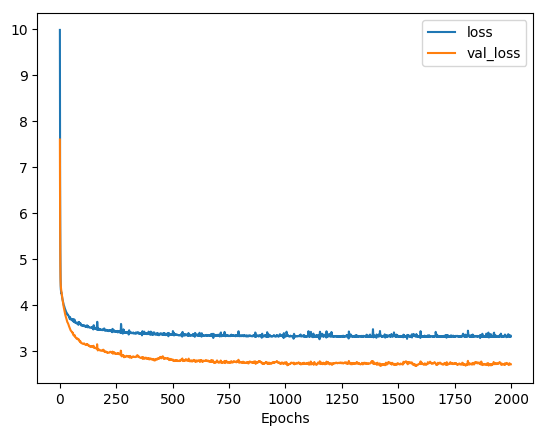

In [20]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')

In [21]:
model = Model(inputs=inputs, outputs=p_y.mean()) 
y_hat_test = model.predict(X_test).flatten()


rmse=np.sqrt(np.mean((y_test - y_hat_test)**2))
mae=np.mean(np.abs(y_test - y_hat_test)) 

NLL = model_p.evaluate(X_test, y_test) #returns the NLL 

df3 = pd.DataFrame(
         { 'RMSE' : rmse, 'MAE' : mae, 'NLL (mean)' : NLL}, index=['Poisson Regression (TFP)']
)
pd.concat([df1,df2,df3])

50/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

,RMSE,MAE,NLL (mean)
Linear Regression (sklearn),8.588126,4.705090,3.617528
Linear Regression (MSE Keras),8.588128,4.705087,3.617528
Poisson Regression (TFP),7.191673,3.117547,2.701041


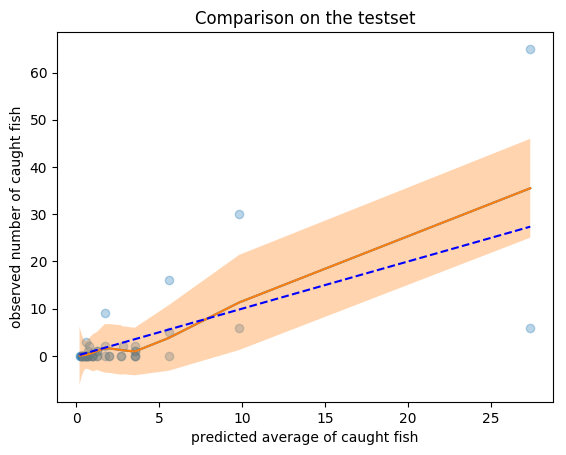

In [22]:
plt.scatter(y_hat_test, y_test, alpha=0.3)
plot_loess(y_hat_test,y_test)
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.show()

You see that the Poission regression is the best model so far, with the lowest NLL on the test data (~2.7) and also the RMSE and the MAE are lower. On the predicted vs true plot you see that the predictions are now a bit better then with the linear regression model. Note that the poission regression model does not predict any negative values. The smallest value is approx. 0.2. In an ideal model, all points would line up on the main diagonal.

### Return to the book 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/Page_turn_icon_A.png" width="120" align="left" />  
Return to the book to learn about zero inflated Poisson Regression.

## Zero inflated Poisson Regression 

You saw that it seems that there are more unlucky groups that did not catch any fish at all, as you would expect from Poisson regression model. To tackle this problem you will define now a model with two outputs, one for the poisson mean and one for the probability that zero fish were caught. This is the so called zero inflated Poisson distribution. You use the TFP framework create a mixture of the Poission distribution and zeros. You will not use any hidden layers in between and the loss will be the NLL. After the fitting, you predict the test data and compare the performance with the linear regression model.



The ZIP needs two parameters:
* the probability 1-p with which zeros are produced
* the rate of a Poisson distribution with probability p


In [0]:
# Listing 5.l_zi
def zero_inf(out): 
    rate = tf.squeeze(tf.math.exp(out[:,0:1])) #A 
    s = tf.math.sigmoid(out[:,1:2]) #B  
    probs = tf.concat([1-s, s], axis=1) #C 
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
          tfd.Deterministic(loc=tf.zeros_like(rate)), #E
          tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We use exponential to guaranty values >0. We use the squeeze function to flatten the tensor.
#B The second component codes for the zero inflation, using sigmoid squeezes the value between 0 and 1.
#C The two probabilities for zeros or Poissonian  
#D The tfd.Categorical allows to create a mixture of two components. 
#E Zero as a deterministic value 
#F Value drawn from a Poissonian

In the next cell you can check if the ZIP distribution is working. For the input values we chose 1 for the input related to the rate of the Poisson and +- 10 for the input connected with the probability to pick the rate. Note that those values are transformed into exp(1) wich is ~2.71 and sigmoid(10) which is almost 1 and sigmoid(-10) which is very close to 0. If you look at the predicted mean of the distribution, you see that the function works. It's is also possible to sample from the distribution.

In [24]:
## testinging the distribution, we evalute some data 

print("rate of the poissonian :", tf.exp(1.0).numpy())
print("probability to pick the rate :" ,tf.math.sigmoid(10.0).numpy())
print("probability to pick the rate :" ,tf.math.sigmoid(-10.0).numpy())


t = np.ones((2,2), dtype=np.float32)
t[0,0] = 1
t[0,1] = 10#almost always take pois 
t[1,0] = 1
t[1,1] = -10# almost always take zero
#t = tf.cast(t, dtype="float32")
print('Input Tensor : ')
print(t)
print('Output Mean  : ',zero_inf(t).mean().numpy())
print('Output Sample  : ',zero_inf(t).sample().numpy())

rate of the poissonian : 2.7182817
probability to pick the rate : 0.9999546
probability to pick the rate : 4.5397872e-05
Input Tensor : 
[[  1.  10.]
 [  1. -10.]]
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.
Output Mean  :  [2.7181582e+00 1.2340420e-04]
Output Sample  :  [2. 0.]


Here you define the network and use the zero_inf distribution.

In [25]:
## Definition of the custom parametrized distribution
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))  
out = Dense(2)(inputs)#A
p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

#A A dense layer is used without activation. The transformation is done inside zero_inf function
model_zi.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
distribution_lambda_1 (Distr ((None,), (None,))        0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


### Training of the model (by hand)with GradientTape [optional]

The following code trains the NN using a evaluation loop by hand. This help us to find instabilities, See also: https://www.tensorflow.org/beta/guide/keras/training_and_evaluation#part_ii_writing_your_own_training_evaluation_loops_from_scratch


In [26]:
optimizer=tf.optimizers.Adam(learning_rate=0.05)
steps=10
loss_values = np.zeros((steps))
for e in range(steps):
    with tf.GradientTape() as tape:
        y_hat = model_zi(X_train)
        loss_value = -tf.reduce_mean(y_hat.log_prob(y_train))
        loss_values[e] = loss_value
        grads = tape.gradient(loss_value, model_zi.trainable_weights)
        weights =  model_zi.trainable_weights       
        optimizer.apply_gradients(zip(grads,weights))
        print(loss_value)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
tf.Tensor(5.224306, shape=(), dtype=float32)
tf.Tensor(4.654831, shape=(), dtype=float32)
tf.Tensor(4.2599382, shape=(), dtype=float32)
tf.Tensor(4.0779867, shape=(), dtype=float32)
tf.Tensor(4.0849843, shape=(), dtype=float32)
tf.Tensor(4.1315565, shape=(), dtype=float32)
tf.Tensor(4.089606, shape=(), dtype=float32)
tf.Tensor(3.9750507, shape=(), dtype=float32)
tf.Tensor(3.853739, shape=(), dtype=float32)
tf.T

### Training using keras' build in training

In [27]:
def NLL(y_true, y_hat):
    return -y_hat.log_prob(tf.reshape(y_true,(-1,)))

model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)
hist_zi = model_zi.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

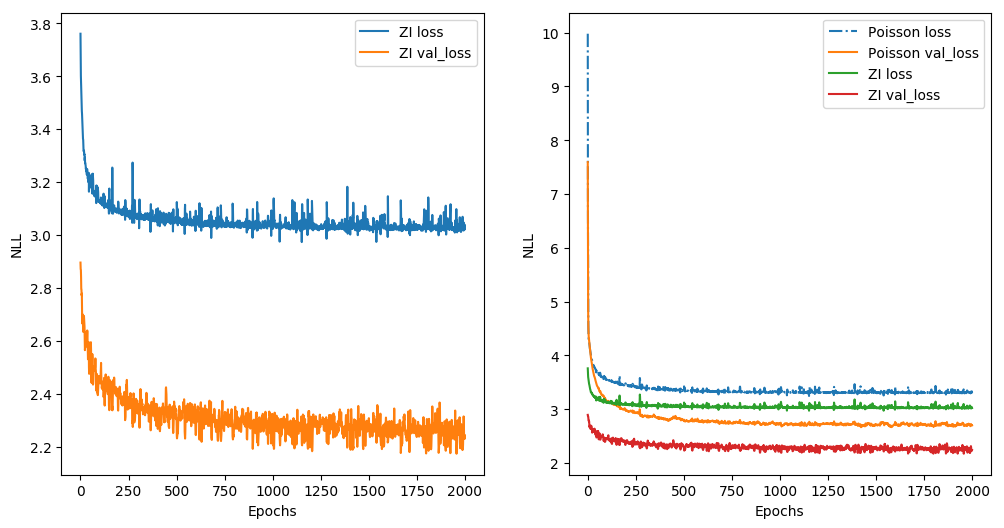

In [28]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.legend(['ZI loss','ZI val_loss'])
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.subplot(1,2,2)
plt.plot(hist_p.history['loss'],linestyle='-.')
plt.plot(hist_p.history['val_loss'])
plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.legend(['Poisson loss','Poisson val_loss','ZI loss','ZI val_loss'])
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.show()

In [29]:
model = Model(inputs=inputs, outputs=p_y_zi.mean()) 
y_hat_test = model.predict(X_test).flatten()


mse=np.sqrt(np.mean((y_test - y_hat_test)**2))
mae=np.mean(np.abs(y_test - y_hat_test)) 

NLL = model_zi.evaluate(X_test, y_test) #returns the NLL 


df4 = pd.DataFrame(
         { 'RMSE' : mse, 'MAE' : mae, 'NLL (mean)' : NLL}, index=['ZIP (TFP)']
)
pd.concat([df1,df2,df3,df4])

50/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

,RMSE,MAE,NLL (mean)
Linear Regression (sklearn),8.588126,4.705090,3.617528
Linear Regression (MSE Keras),8.588128,4.705087,3.617528
Poisson Regression (TFP),7.191673,3.117547,2.701041
ZIP (TFP),7.334542,3.167983,2.243332


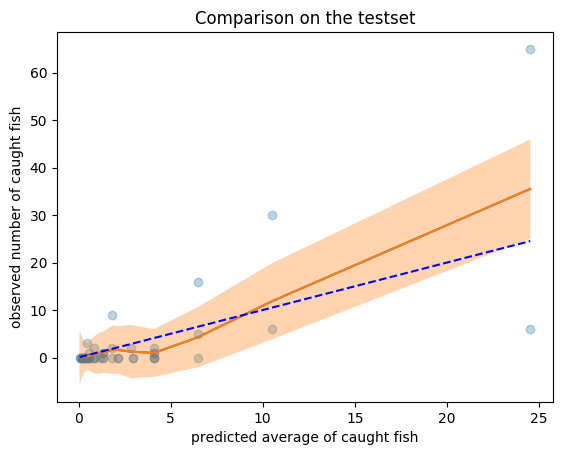

In [30]:
plt.scatter(y_hat_test, y_test, alpha=0.3)
plot_loess(y_hat_test,y_test)
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.show()

Note that the ZIP model is not so much better then the Poisson model. Let's see what happens if you make more fisherman unlucky and remove randomly remove some catched. You can uncomment the lines in cell 5.